In [82]:
import numpy as np
import sys
sys.path.append("../source")
import numpy as np
from abess.datasets import make_glm_data
from abess import linear 
from sparse_coordinate_descent import SCD
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import time

<!-- For Gamma Regression, $f(y;x^{\top}\beta, \phi)=\exp\left\{yx^{\top}\beta-e^{x^{\top}\beta}-\log(y!)\right\}$  
The loss function is $h(\beta)=\frac{1}{n}\sum_{i=1}^n[e^{x_i^{\top}\beta}-y_ix_i^{\top}\beta]$ -->

### 数据生成

In [83]:
def make_gamma_data(n, p, s, rho=0, random_state=None, snr=1):
    # 创建随机数生成器
    rng = np.random.default_rng(random_state)
    
    # 使用向量化方法生成相关系数矩阵
    i, j = np.meshgrid(np.arange(p), np.arange(p))
    R = rho ** np.abs(i - j)
    
    # 生成多元正态分布数据
    X = rng.multivariate_normal(mean=np.zeros(p), cov=R, size=n) * snr
    
    coef = np.zeros(p)
    support = np.sort(rng.choice(range(p), s, replace=False))
    coef[support] = 1 / s
    signal = X @ coef
    signal = np.clip(signal, -20, 20)
    # Possion parameter λ
    lambda_ = np.exp(signal)
    y = rng.poisson(lam=lambda_)

    return X, y, coef

### 模型配置

In [84]:
# model config
def loss_fn(X, y, w):
    loss = np.mean(np.exp(X @ w) - y * (X @ w))
    return loss

def grad_fn(X, y, w):
    n = len(y)
    grad = (X.T @ np.exp(X @ w) - X.T @ y) / n
    return grad

def eval_acc(a, b):
    acc = len(set(a) & set(b)) / s
    return acc

def eval_err(u, v):
    err = np.linalg.norm(u - v)
    return err

p, s = 500, 10
snr = 2
model_dict = {
    "SCD": SCD(sparsity=s, loss_fn=loss_fn, grad_fn=grad_fn),
    "ABESS": linear.PoissonRegression(support_size=s),
}

### 模拟实验

In [86]:
# simulation

result = []
for i in range(100):
    for n, rho in product(range(100, 1001, 100), [-0.8, 0, 0.8]):
        X, y, coef_true = make_poisson_data(n=n, p=p, s=s, snr=snr, )
        support_true = np.nonzero(coef_true)[0]
        for name, model in model_dict.items():
            t0 = time.perf_counter()
            model.fit(X, y)
            t = time.perf_counter() - t0
            coef_est = model.coef_
            support_est = np.nonzero(coef_est)[0]
            acc = eval_acc(support_true, support_est)
            err = eval_err(coef_true, coef_est)
            print(f"{i}-th, {n}, {rho}, {name}, Acc : {acc:.2f}, Err: {err:.5f}, Time: {t:.5f}")
            result.append([n, rho, name, acc, err, t])

# 将result转换为DataFrame
result_df = pd.DataFrame(result, columns=["n", "rho", "method", "accuracy", "error", "time"])

0-th, 100, -0.8, SCD, Acc : 0.10, Err: 0.43451, Time: 0.01630
0-th, 100, -0.8, ABESS, Acc : 0.20, Err: 0.52555, Time: 0.00343
0-th, 100, 0, SCD, Acc : 0.50, Err: 0.31947, Time: 0.01697
0-th, 100, 0, ABESS, Acc : 0.30, Err: 0.49130, Time: 0.00381
0-th, 100, 0.8, SCD, Acc : 0.30, Err: 0.38361, Time: 0.01480
0-th, 100, 0.8, ABESS, Acc : 0.30, Err: 0.46809, Time: 0.00276
0-th, 200, -0.8, SCD, Acc : 0.70, Err: 0.25913, Time: 0.01676
0-th, 200, -0.8, ABESS, Acc : 0.60, Err: 0.33740, Time: 0.00447
0-th, 200, 0, SCD, Acc : 0.80, Err: 0.18161, Time: 0.01733
0-th, 200, 0, ABESS, Acc : 0.60, Err: 0.30493, Time: 0.00382
0-th, 200, 0.8, SCD, Acc : 0.80, Err: 0.18086, Time: 0.01848
0-th, 200, 0.8, ABESS, Acc : 0.60, Err: 0.34483, Time: 0.00405
0-th, 300, -0.8, SCD, Acc : 0.80, Err: 0.19574, Time: 0.01500
0-th, 300, -0.8, ABESS, Acc : 0.80, Err: 0.20129, Time: 0.00463
0-th, 300, 0, SCD, Acc : 0.50, Err: 0.31576, Time: 0.01512
0-th, 300, 0, ABESS, Acc : 0.40, Err: 0.31803, Time: 0.00442
0-th, 300, 0.8

### 结果可视化

In [87]:
result_df = pd.DataFrame(result, columns=["n", "rho", "method", "accuracy", "error", "time"])
grouped_df = pd.melt(
    result_df,
    id_vars=["n", "rho", "method"],
    value_vars=["accuracy", "error", "time"],
    var_name="metrics",
    value_name="value"
).groupby(
    ["n", "rho", "method", "metrics"]
).mean().reset_index()
grouped_df

,n,rho,method,metrics,value
0,100,-0.8,ABESS,accuracy,0.188000
1,100,-0.8,ABESS,error,0.527554
2,100,-0.8,ABESS,time,0.003309
3,100,-0.8,SCD,accuracy,0.282000
4,100,-0.8,SCD,error,0.376586
...,...,...,...,...,...
175,1000,0.8,ABESS,error,0.045630
176,1000,0.8,ABESS,time,0.007904
177,1000,0.8,SCD,accuracy,0.999000
178,1000,0.8,SCD,error,0.042058


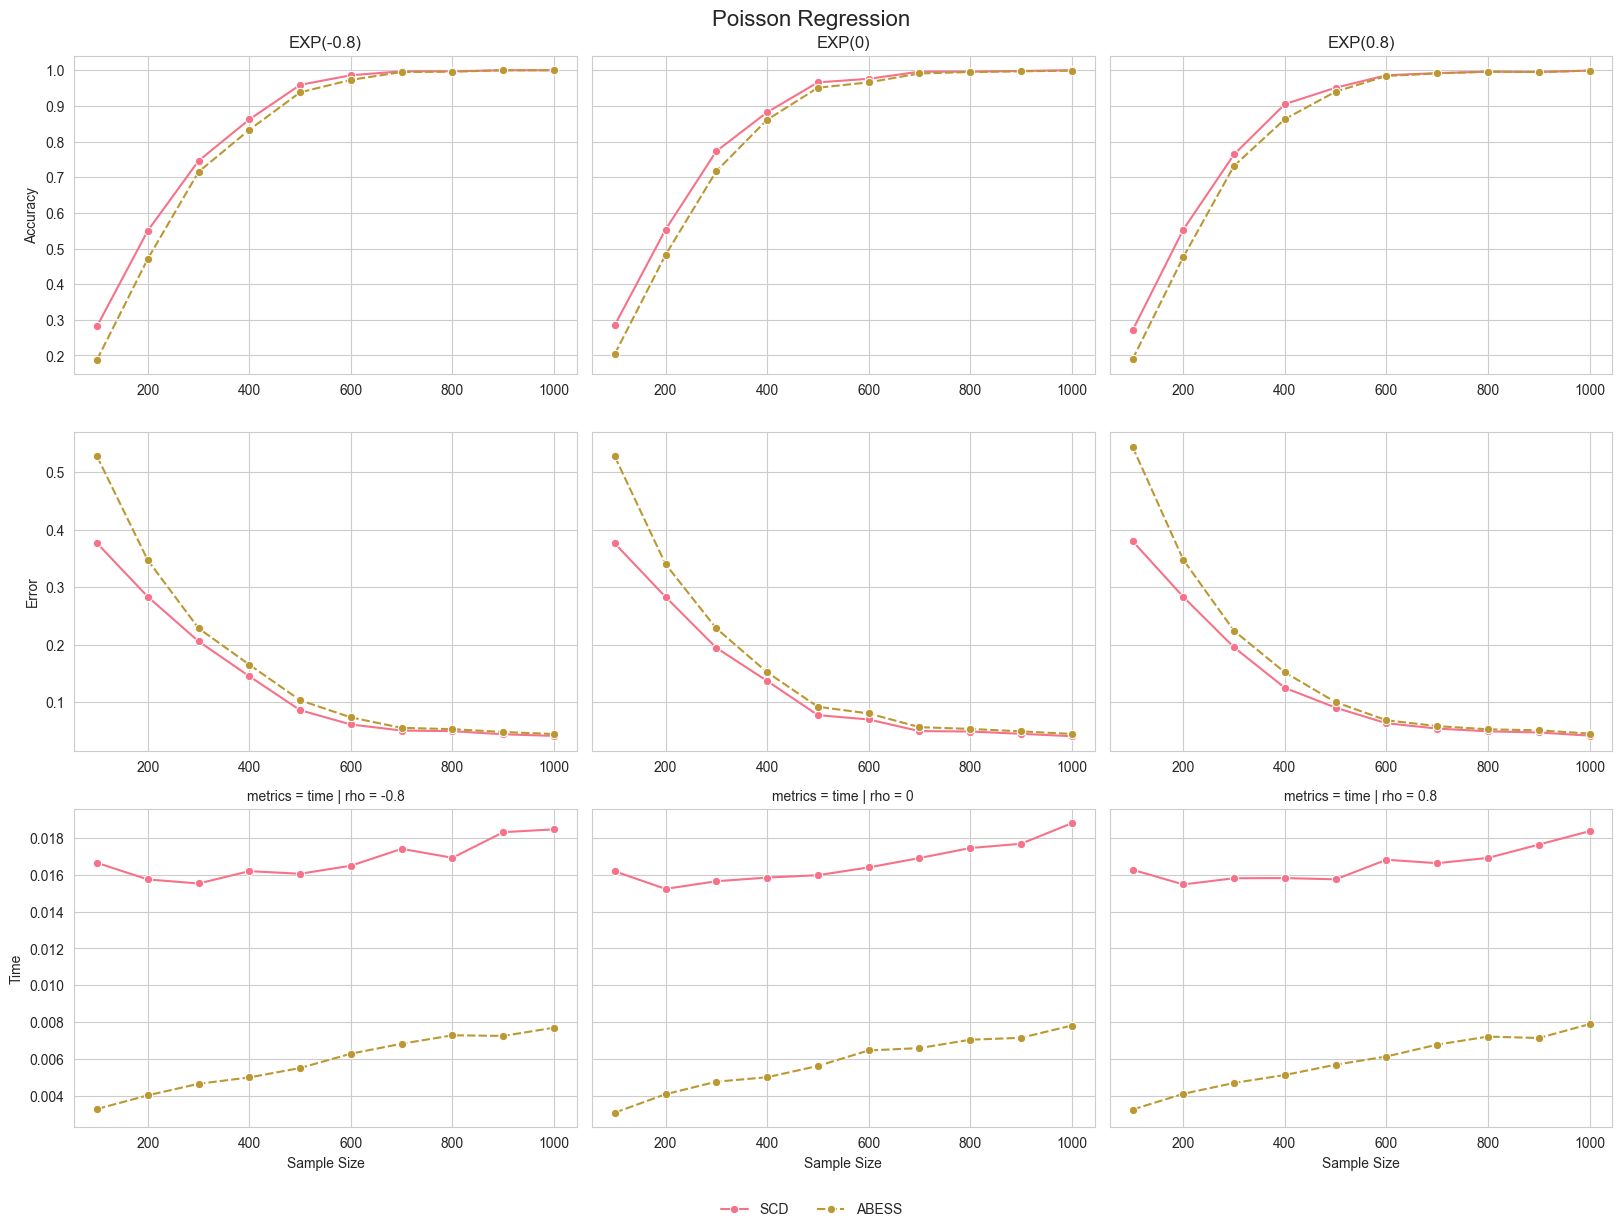

In [91]:
# 设置seaborn样式
sns.set_style("whitegrid")
sns.set_palette("husl")

# 创建FacetGrid
row_order = ["accuracy", "error", "time"]
col_order = [-0.8, 0, 0.8]
g = sns.FacetGrid(
    grouped_df,
    row="metrics",
    col="rho",
    row_order=row_order,
    col_order=col_order,

    height=4,
    aspect=1.2,
    sharex=False,
    sharey="row",
)

hue_order = ["SCD", "ABESS"]
g.map_dataframe(
    sns.lineplot, 
    x="n", 
    y="value", 
    hue="method", 
    style="method",
    hue_order=hue_order,
    style_order=hue_order,
    marker="o"
)
# 设置坐标轴标签
g.set_axis_labels("Sample Size", "")

# 设置行标签
for ax, label in zip(g.axes[:, 0], ["Accuracy", "Error", "Time"]):
    ax.set_ylabel(label)

# 修改第一行标题
for i, ax in enumerate(g.axes[0, :]):
    ax.set_title(f"EXP({col_order[i]})")

# 移除第二行的标题
for ax in g.axes[1, :]:
    ax.set_title("")

# 显示所有子图的边框
for ax in g.axes.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

# 调整图例位置
g.add_legend(
    # title="Method", 
    bbox_to_anchor=(0.5, -0.02), 
    loc="center", 
    ncol=len(model_dict)
)

plt.suptitle("Poisson Regression", fontsize=16)
plt.tight_layout()
plt.savefig("result/poisson_regression_results.pdf", dpi=500, bbox_inches="tight")
plt.show()

In [89]:
# # 按n和method分组计算平均值
# grouped_df = result_df.groupby(["n", "method"]).mean().reset_index()

# # 设置seaborn样式
# sns.set_style("whitegrid")
# sns.set_palette("husl")

# # 创建两个子图
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# # 绘制准确率折线图
# sns.lineplot(data=grouped_df, x="n", y="accuracy", hue="method", marker="o", ax=ax1)
# ax1.set_xlabel("Sample Size")
# ax1.set_ylabel("Accuracy")
# ax1.set_title("Poisson Regression")

# # 绘制误差折线图
# sns.lineplot(data=grouped_df, x="n", y="error", hue="method", marker="o", ax=ax2)
# ax2.set_xlabel("Sample Size")
# ax2.set_ylabel("Error")
# ax2.set_title("Poisson Regression")

# plt.tight_layout()
# plt.show()